<a href="https://colab.research.google.com/github/Agalip/Clustering-Countries-by-Covid-19-Community-Mobility-Reports-and-Visualization-on-World-Map/blob/main/Data%20Mining%20Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

January 2022

@Ahmet Galip Şengün - ahmetgalipsengun@gmail.com

Istanbul Medeniyet University

# Clustering Countries by Covid-19 Community Mobility Reports and Visualization on World Map

## Introduction

This study aims to cluster countries and find a possible relationship by examining the mobility data of countries during the covid period. This relationship may be geographical, cultural, religious or so.
Plotting these clusters on the world map will help us find out whether there is a relationship, and if so, what kind of relationship it is.

## Initial imports and installs

In [6]:
pip install geopandas

In [7]:
pip install folium

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
%matplotlib inline

## Google Mobility Data

These Community Mobility Reports aim to provide insights into what has changed in response to policies aimed at combating COVID-19. The reports chart movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential.

More details on the data can be found on the Google's Mobility Reports website

https://www.google.com/covid19/mobility/data_documentation.html?hl=en

Accessing to dataset through local csv file,

The dataset can be downloaded from https://www.google.com/covid19/mobility/

In [9]:
##data = pd.read_csv('Global_Mobility_Report.csv', low_memory=False)
data = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', low_memory=False)
data.drop('census_fips_code', axis =1, inplace = True)

In [10]:
data.describe()

retail_and_recreation_percent_change_from_baseline  ...  residential_percent_change_from_baseline
count                                       5.254350e+06   ...                              5.145941e+06
mean                                       -1.356405e+01   ...                              7.196105e+00
std                                         2.937437e+01   ...                              7.486471e+00
min                                        -1.000000e+02   ...                             -7.100000e+01
25%                                        -3.000000e+01   ...                              2.000000e+00
50%                                        -1.100000e+01   ...                              6.000000e+00
75%                                         4.000000e+00   ...                              1.100000e+01
max                                         6.160000e+02   ...                              7.000000e+01

[8 rows x 6 columns]

In [11]:
data

country_region_code  ... residential_percent_change_from_baseline
0                        AE  ...                                      1.0
1                        AE  ...                                      1.0
2                        AE  ...                                      1.0
3                        AE  ...                                      1.0
4                        AE  ...                                      1.0
...                     ...  ...                                      ...
8490825                  ZW  ...                                      NaN
8490826                  ZW  ...                                      NaN
8490827                  ZW  ...                                      NaN
8490828                  ZW  ...                                      NaN
8490829                  ZW  ...                                      NaN

[8490830 rows x 14 columns]

## Inspecting the data

Plotting of graphs for observing the mobility data of several countries during the covid period in order to
check how different the mobility reports can be in different countries

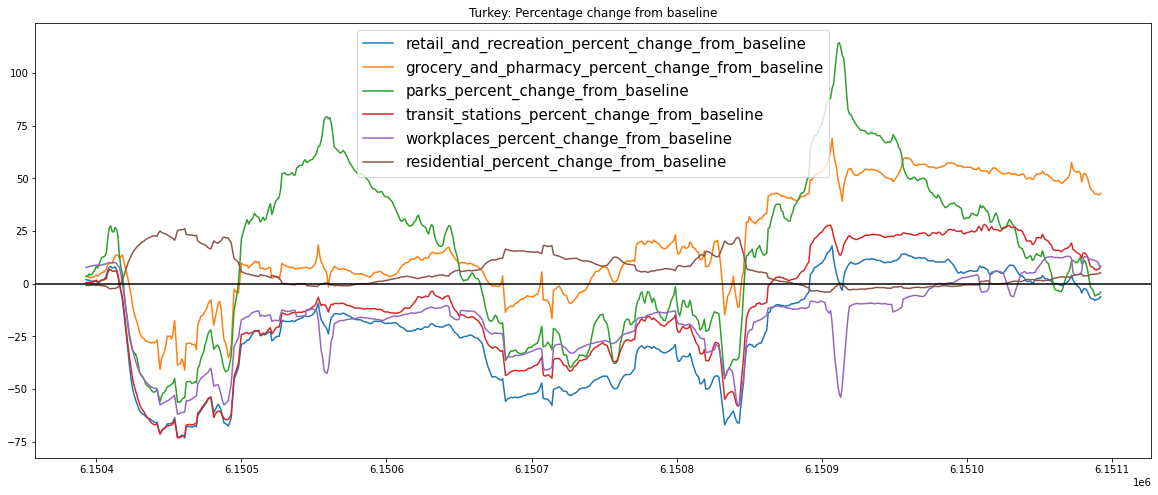

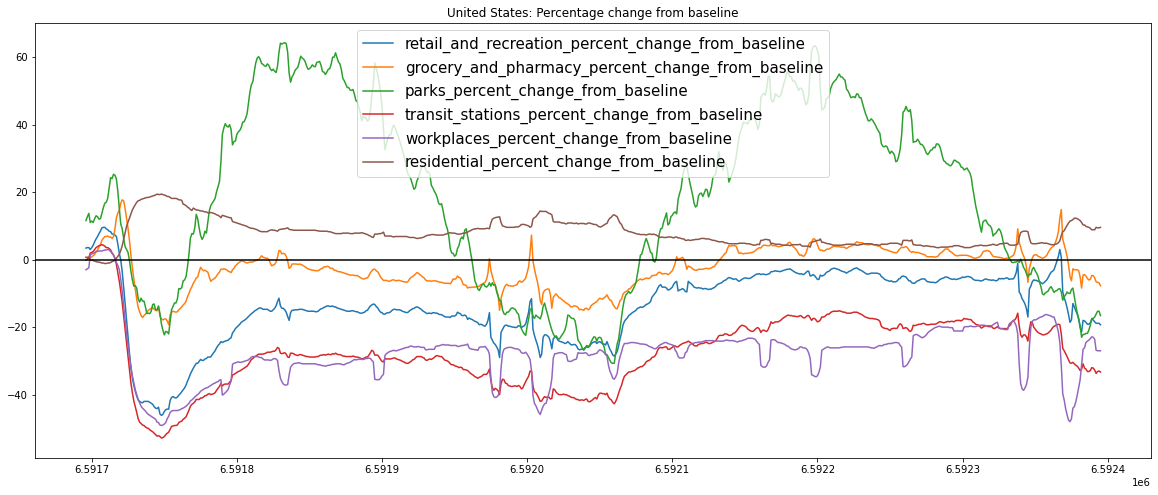

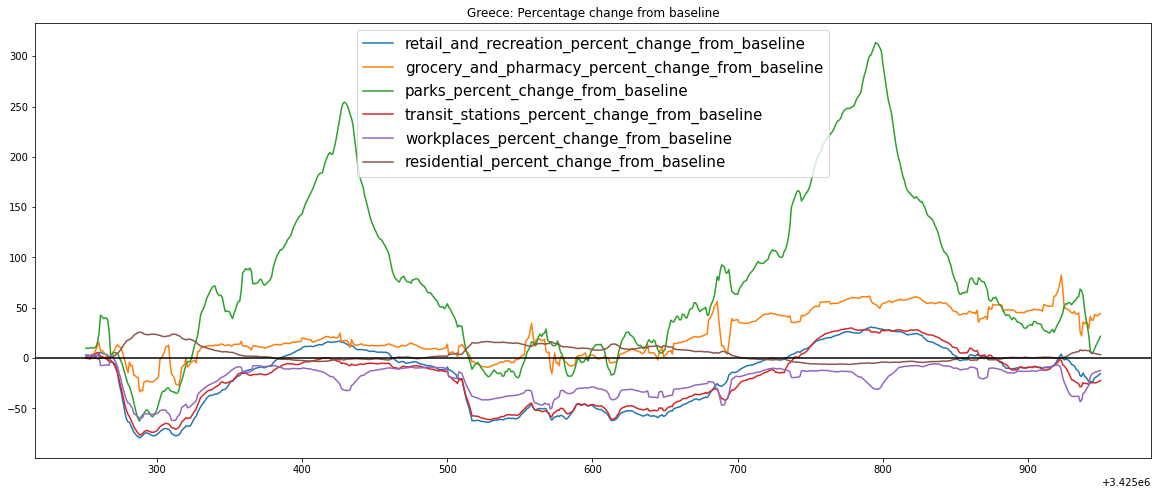

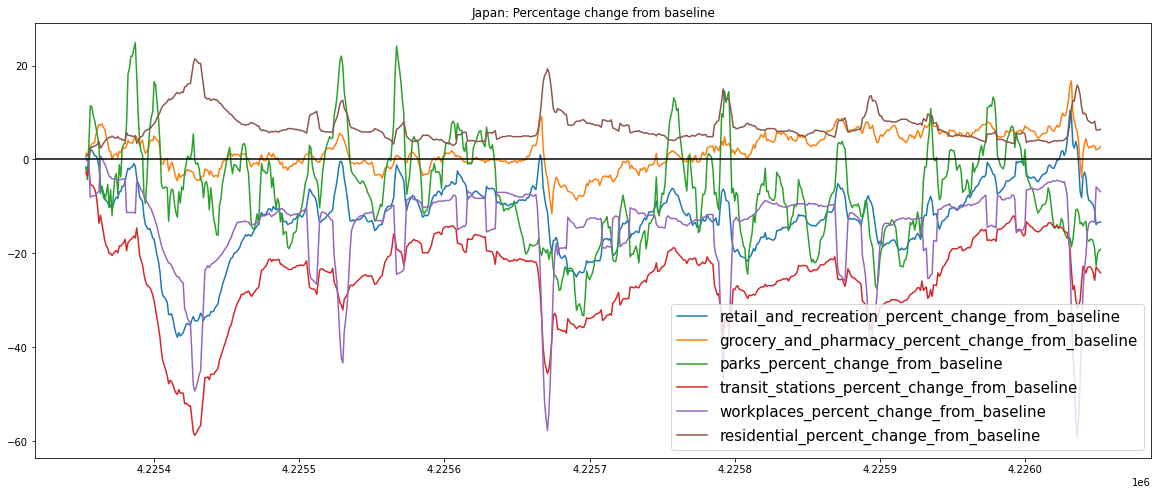

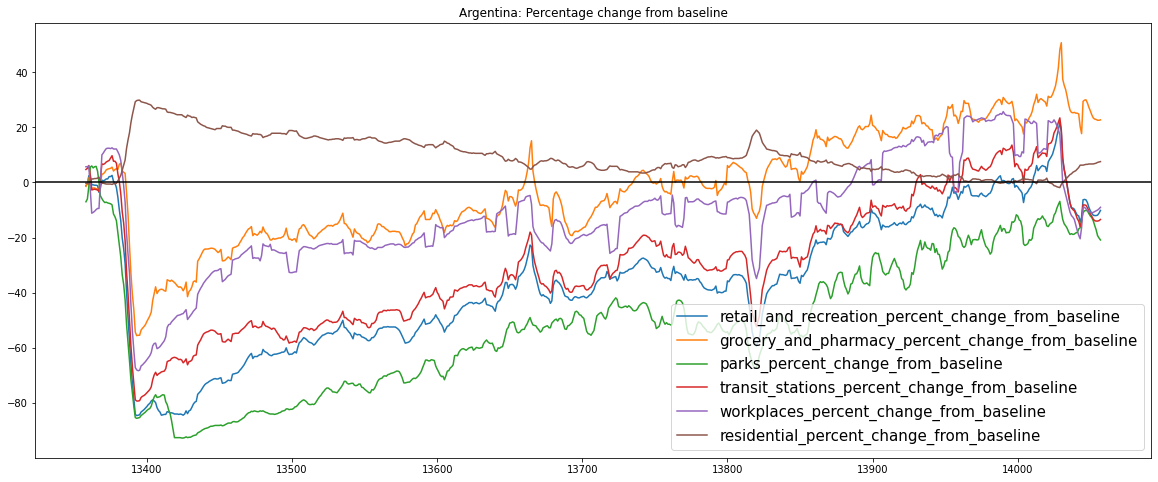

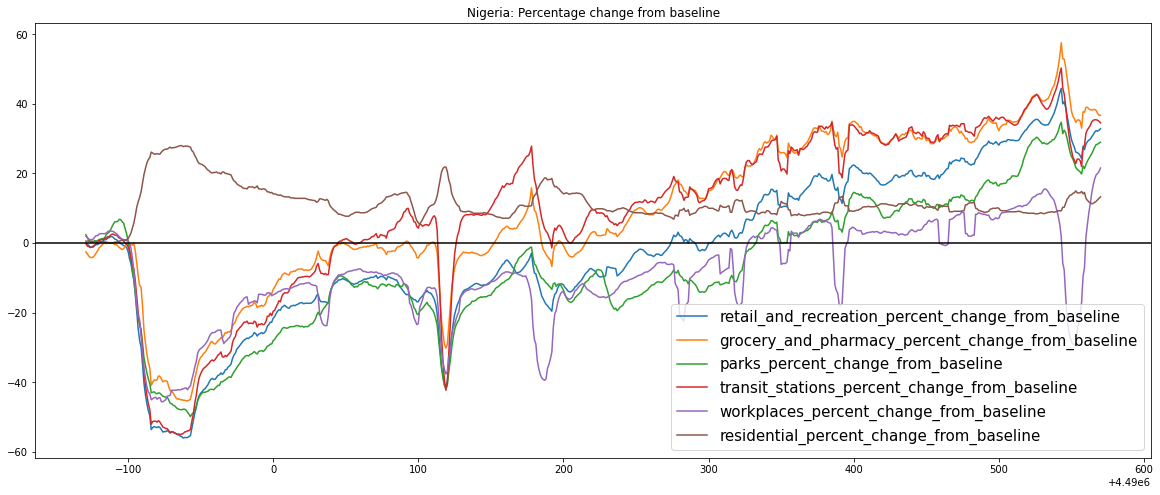

In [12]:
date_date = data.set_index('date')
date_date.index = pd.to_datetime(date_date.index)
countries = ['Turkey', 'United States', 'Greece', 'Japan', 'Argentina', 'Nigeria']
for country in countries:
    country_data = data.query('country_region == @country')
    country_data[country_data['sub_region_1'].isnull()].drop(['sub_region_1', 'sub_region_2'], axis=1).rolling(7).mean().plot(figsize = (20,8))
    plt.legend(loc="best", fontsize =15)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.title(country+': Percentage change from baseline')

As can be seen above, the mobility data of different countries can be similar to each other or very different.

For example, if we look at the change in the data going to the parks,
while the rate of going to the parks increases in Turkey, United States and Greece in the summer months, we can observe that there is a zig-zag graph in Japan, the downward trend continues in Argentina, and it gradually increases after the initial decline in Nigeria.

## The relationship between the mobility categories

Plotting the relationship between mobility categories against each other for turkey.

Although this chart may vary from country to country, it is intended to give a preliminary idea of the relationship between the categories.

Text(0.5, 0.98, 'Turkey: The relationship between the mobility categories against each other')

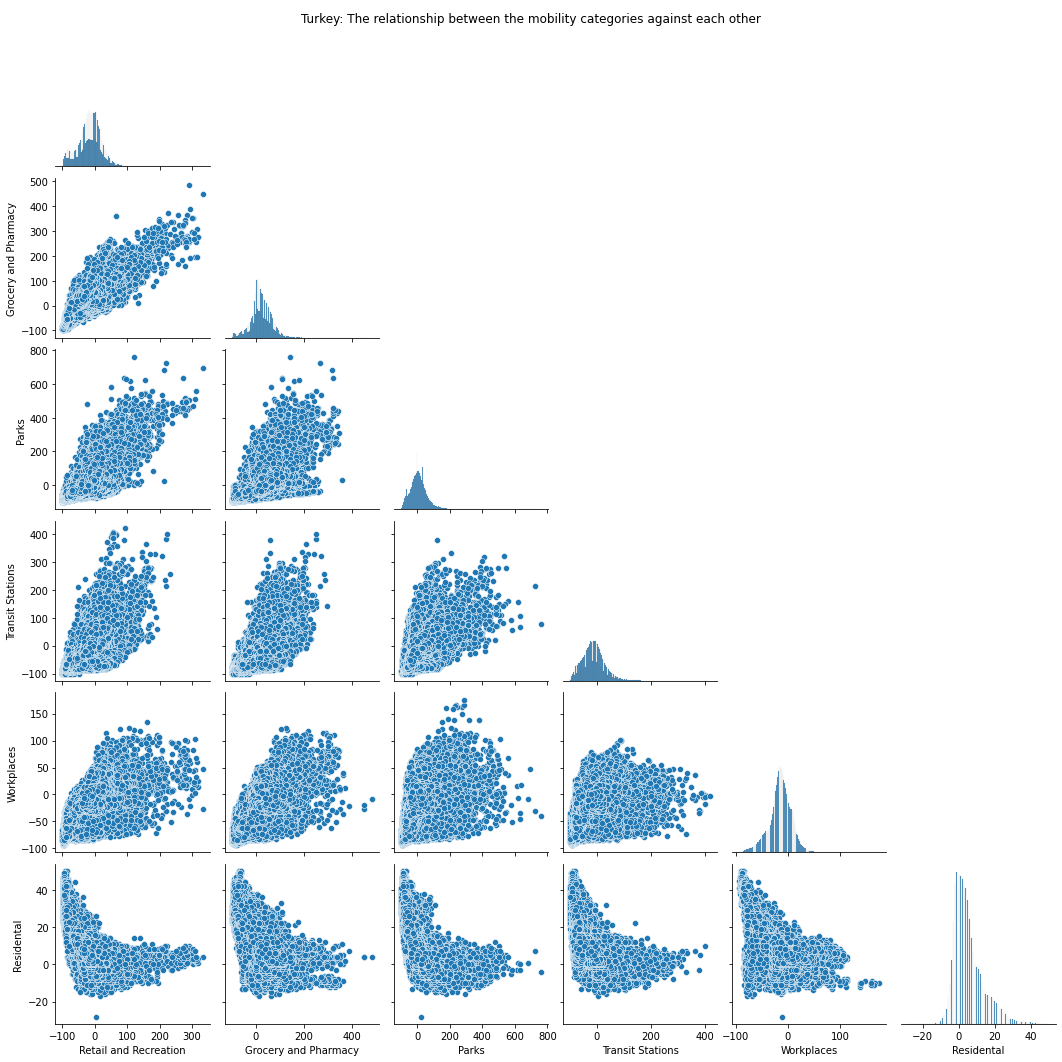

In [13]:
country = 'Turkey'
renamed_data = data.rename({'retail_and_recreation_percent_change_from_baseline' : 'Retail and Recreation',
                           'grocery_and_pharmacy_percent_change_from_baseline' : 'Grocery and Pharmacy',
                           'parks_percent_change_from_baseline' : 'Parks',
                           'transit_stations_percent_change_from_baseline' : 'Transit Stations',
                           'workplaces_percent_change_from_baseline' : 'Workplaces',
                           'residential_percent_change_from_baseline' : 'Residental'}, axis=1)
country_data = renamed_data.query('country_region == @country')
g = sns.pairplot(country_data.iloc[:,7:], corner = True)
g.fig.suptitle(country+ ": The relationship between the mobility categories against each other")

## High Dimensional Clustering

In this section we will cluster countries using all categories of mobility data.

We will use the DBSCAN algorithm for clustering. So why did we choose to use DBSCAN? Because we did not have much value to determine the input parameters (for example, the k value in the k-means algorithm), its good efficiency in large databases and clusters with random shapes was effective in choosing the DBSCAN algorithm.

Detailed information about the DBSCAN algorithm https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

Detailed information on using the DBSCAN algorithm in high-dimensional datasets https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6

## Preprocessing for High Dimensional Clustering

Let's take the average of the columns and make them suitable for the classification algorithm.

In [14]:
clustering_gmt_df = data.groupby('country_region').mean().reset_index()
clustering_gmt_df.head()

country_region  ...  residential_percent_change_from_baseline
0          Afghanistan  ...                                  3.837368
1               Angola  ...                                  4.300283
2  Antigua and Barbuda  ...                                  1.037004
3            Argentina  ...                                  7.692075
4                Aruba  ...                                  1.839181

[5 rows x 7 columns]

After that let's write the algorithm

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

X = clustering_gmt_df.iloc[:,1:]
X = X.fillna(0)
X = StandardScaler().fit_transform(X) 

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

First, let's calculate the distances of each point to its nearest neighbor using the NearestNeighbors algorithm.

We'll use the "minkowski distance" as the metric.

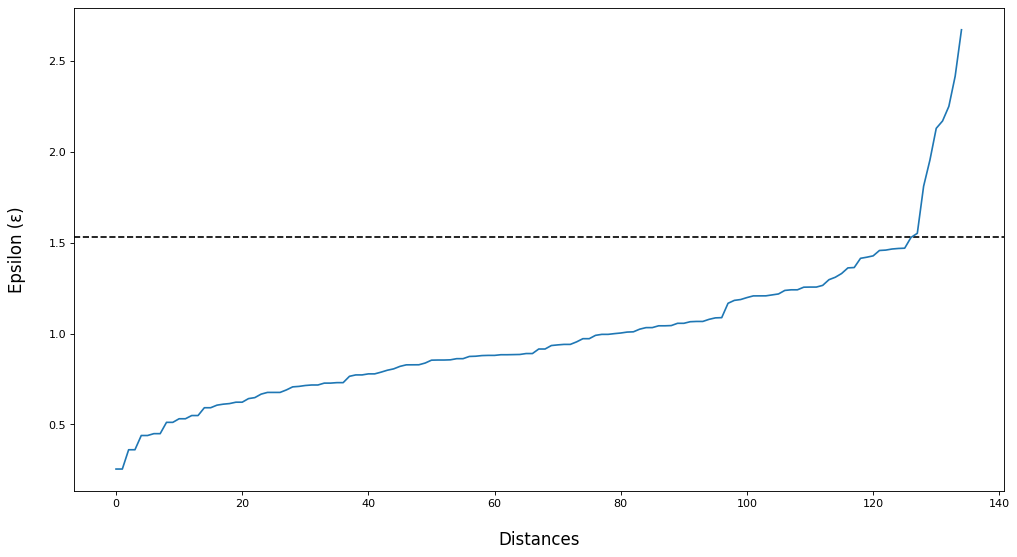

In [16]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize = (15,8), dpi = 80)
plt.xlabel("Distances", fontdict= {'size':15}, labelpad= 20)
plt.ylabel("Epsilon (ɛ)", fontdict= {'size':15}, labelpad= 20)
plt.axhline(1.53, linestyle='--', color='k')
plt.plot(distances)

Then we found the epsilon values that define the maximum distance between two points and we got the graph you see above.

The optimal value for Epsilon is found at the point of maximum curvature. This equates to around 1.53.

## DBSCAN Clustering

Then we ran the DBSCAN algorithm for epsilon 1.53.

Estimated number of clusters: 3
Estimated number of noise points: 18


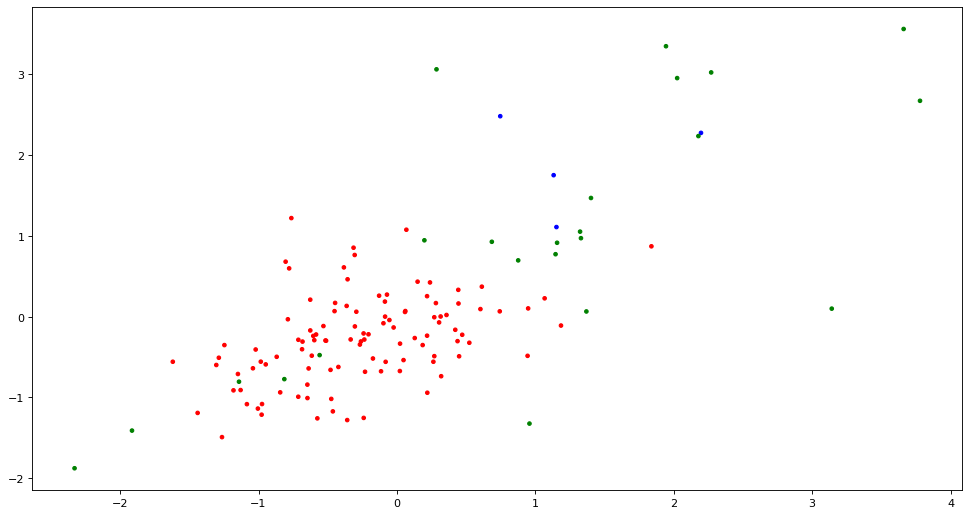

In [17]:
m = DBSCAN(eps=1.53)
m.fit(X)

core_samples_mask = np.zeros_like(m.labels_, dtype=bool)
core_samples_mask[m.core_sample_indices_] = True
labels = m.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

colors = ['red', 'blue', 'green']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
plt.figure(figsize = (15,8), dpi = 80)
plt.scatter(X[:,0], X[:,1], c=vectorizer(labels), s=10)

And as you can see we got two clusters.

Apart from these two clusters, there is also a "noise" cluster, which includes countries that are not included in these two clusters.

The -1 cluster is the noise cluster according to the DBSCAN algorithm.

In [18]:
clustering_gmt_df['cluster'] = labels
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  ...  residential_percent_change_from_baseline
0       -1  ...                                  3.424588
1        0  ...                                  6.242364
2        1  ...                                  4.070349
3        2  ...                                  7.484527

[4 rows x 7 columns]

If we look at the '0' cluster; In general, it is seen that there is a decrease in the mobility in entertainment, transportation and workplaces, while there is an increase in the mobility in the residential areas.

If we look at the '1' cluster, we see that the mobility values are a bit inconsistent, the 'grocery and pharmacy' mobility is quite high, in general there is a movement opposite to what is expected from the covid period.

The set '-1' is the noise set. Outliner countries are gathered in this cluster.

In [19]:
clusters = np.array(clustering_gmt_df['cluster'].unique())
clusters= np.sort(clusters)

In [20]:
def print_clusters(clusters):
    for i in clusters:
        print("\n")
        print(str(i)+ ". cluster")
        print("--------------------------------------------------------------------------------------------------------------------")
        print(clustering_gmt_df[clustering_gmt_df['cluster'] == i]['country_region'].values.tolist(), end=" ")
        print("\n--------------------------------------------------------------------------------------------------------------------")

Let's print the countries divided into clusters

In [21]:
print_clusters(clusters)



-1. cluster
--------------------------------------------------------------------------------------------------------------------
['Burkina Faso', 'Cameroon', 'Cape Verde', "Côte d'Ivoire", 'Egypt', 'Iraq', 'Kazakhstan', 'Lebanon', 'Libya', 'Mali', 'Mongolia', 'Myanmar (Burma)', 'Niger', 'Panama', 'Papua New Guinea', 'Rwanda', 'Vietnam', 'Yemen'] 
--------------------------------------------------------------------------------------------------------------------


0. cluster
--------------------------------------------------------------------------------------------------------------------
['Angola', 'Antigua and Barbuda', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany',

As can be seen, most of the countries are gathered in cluster 0.

Afghanistan, which has gone through the war and whose mobility data is not expected to be similar to other countries, was not included in this cluster and was included in the 1st cluster. Other countries included in the 1st cluster are the African countries 'Benin' and 'Botswana'.

## DBSCAN visualization on world map

We finished clustering the countries, now let's show these clusters on the map

In [22]:
def clusterCountries(n):
    df0 = pd.DataFrame(data['country_region'].unique(), columns = ['Country'])
    df0['Clusters'] = np.nan
    df0 = df0.set_index('Country')
    for i in n:
        df0.loc[clustering_gmt_df[clustering_gmt_df['cluster'] == i]['country_region'].values.tolist(), 'Clusters'] = i
    return df0
df0 = clusterCountries(clusters)

In [23]:
import folium

def showMap(df0):
    world = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

    world.iloc[4,2] = "United States"
    yeniDf = world.merge(df0, how="left", left_on=['name'], right_on=['Country'])

    my_map = folium.Map()

    # Add the data
    folium.Choropleth(
        geo_data=yeniDf,
        data=yeniDf,
        name='choropleth',
        columns=['name', 'Clusters'],
        fill_color='YlGnBu',
        smooth_factor =1,
        key_on='feature.properties.name',
        fill_opacity=0.8,
        line_opacity=0.5,
        overlay = True,
        legend_name='Clusters',
        nan_fill_color = 'White'
    ).add_to(my_map)
    return my_map
showMap(df0)

On the map, we can see that cluster 0 countries cover almost the entire map. We see that the countries that are not in the core countries cluster are some African and Asian countries.

So what does this map tell us?

When we build our model using all mobility categories, we see that countries are mostly in the same cluster. Although we can see countries that have experienced the Covid period very differently from other countries, it would not be right to comment that the central cluster is too large and the attitudes of the clustered countries are the same during the covid period.

So how do we find more specific sets?

If we create a model by choosing two clusters that can be related to each other, without collecting all the mobility categories in a single model, we can reach more distinctive and meaningful clusters.

## 2 Dimensional Clustering for parks and residental change from baseline

In this section, we will cluster the countries by choosing 2 categories from their mobility data. We will use the K-Means algorithm for clustering.

Why did we use the K-Means algorithm?

The K-Means algorithm is one of the most popular clustering algorithms. Due to the performance advantage it provides, it enables us to cluster large data more easily and in a short time. We thought it would be useful to use the K-Means algorithm since the data we have is large.

One of the disadvantages is; Since the K-Means algorithm is a partitioning algorithm, it does not find the clusters, it divides the dataset into as many pieces as we want by trying to minimize the distances in the dataset. For this, we need to specify exactly how many clusters we want to the K-Means algorithm. To do this, we looked at the 'silhouette score' values ​​of the clusters and the 'dendogram' graph. As a result, we decided how many clusters we would divide and ran the K-Means algorithm.

For detailed information about silhouette analysis https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

As can be seen in the country charts, the rate of change in going to parks varies greatly from country to country. The change in settlements generally indicates the country's stay at home, quarantine situation, covid restrictions or the public's attitude to the coronavirus. Therefore, together with the park, we decided to choose these two as a criterion by which we can distinguish the countries.

In [25]:
clustering_gmt_df = data.groupby('country_region').mean().reset_index() ##resetting
dim2_clustering_df = clustering_gmt_df[['parks_percent_change_from_baseline', 'residential_percent_change_from_baseline']]
dim2_clustering_df = dim2_clustering_df.fillna(0)
X = StandardScaler().fit_transform(dim2_clustering_df)

As we mentioned under the previous title, we need to specify exactly how many clusters we want to the K-Means algorithm.

## Selecting the number of clusters with silhouette analysis

In [26]:
def silhouetteAnalysis(X):
    range_n_clusters = [3, 4, 5, 6, 7]
    silhouette_avg_max = -1
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > silhouette_avg_max:
            silhouette_avg_max = silhouette_avg
            opt_n_clusters = n_clusters
            
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
    
    ##print("choosen cluster size: " + str(opt_n_clusters))    
    plt.show()
    return opt_n_clusters

For n_clusters = 3 The average silhouette_score is : 0.39214758581745857
For n_clusters = 4 The average silhouette_score is : 0.3728832447074653
For n_clusters = 5 The average silhouette_score is : 0.38405925369743116
For n_clusters = 6 The average silhouette_score is : 0.3748518345605544
For n_clusters = 7 The average silhouette_score is : 0.3795953343555879


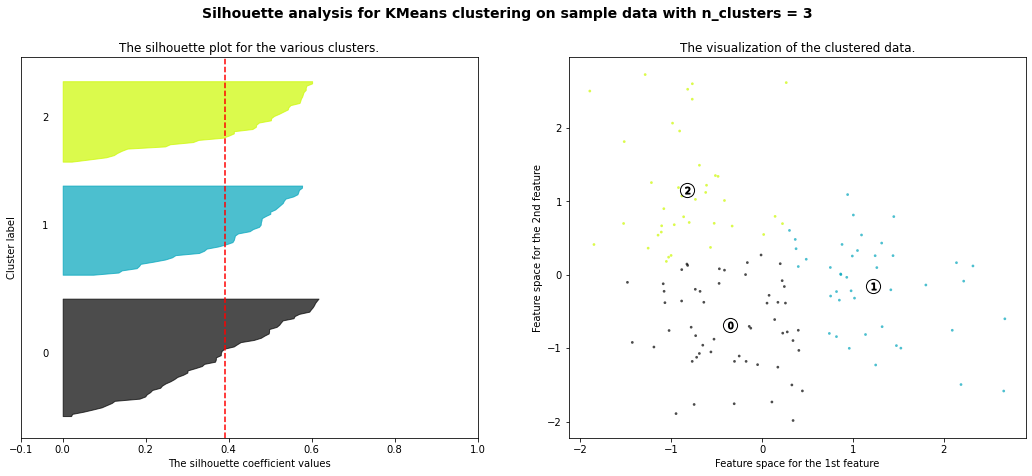

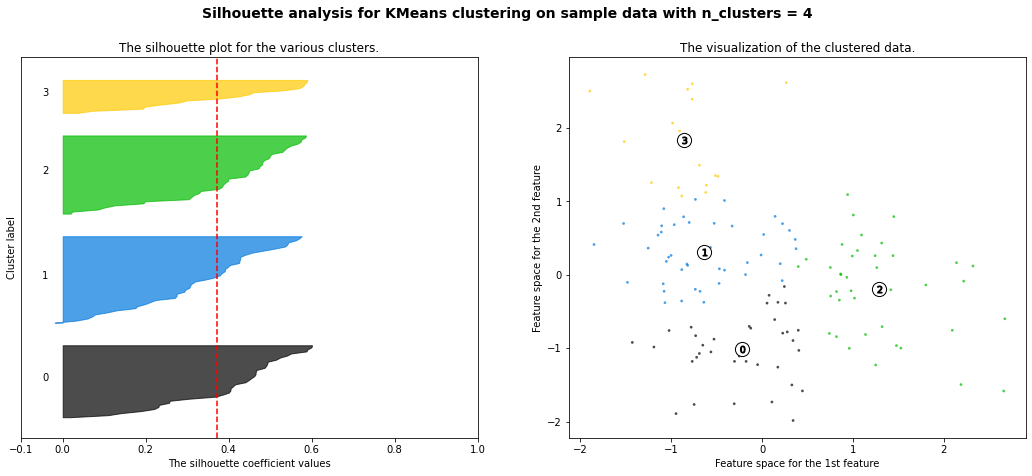

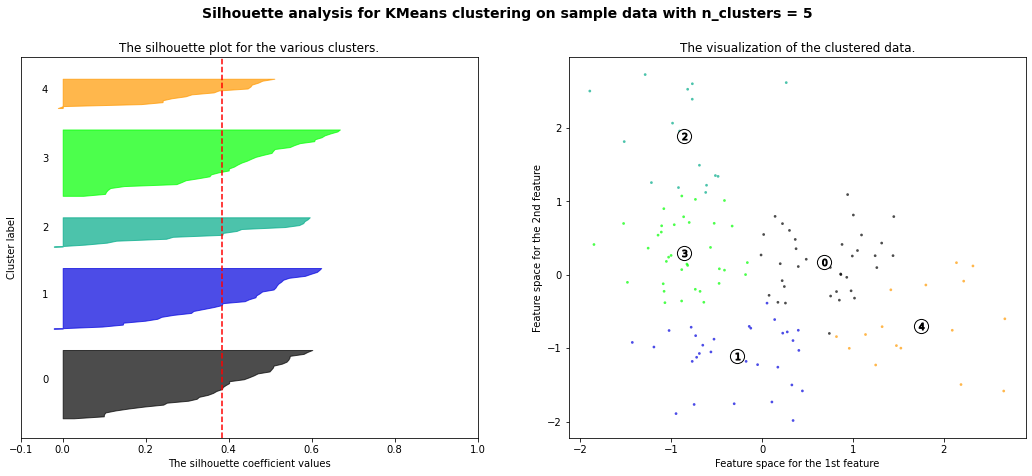

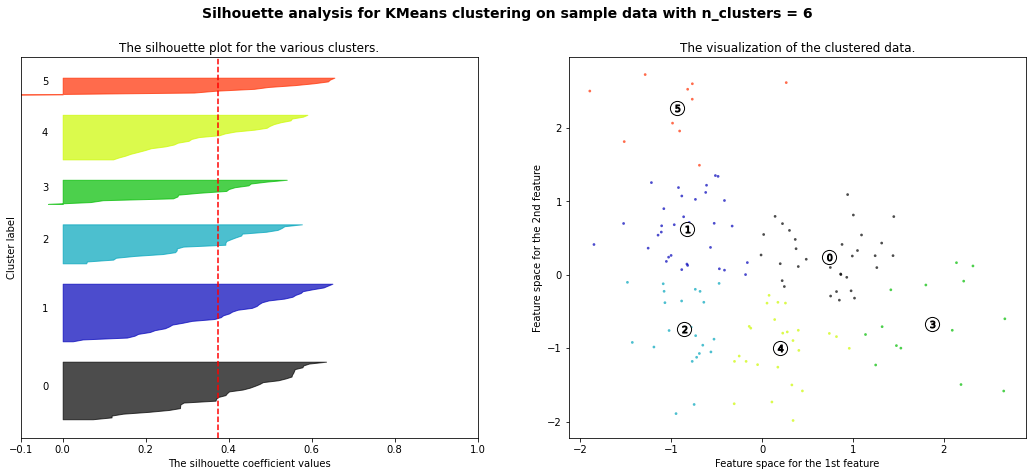

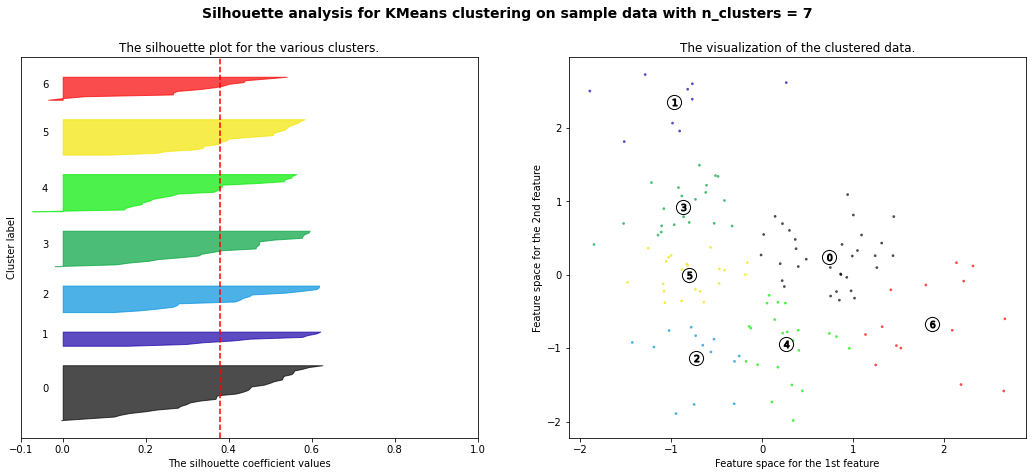

3

In [27]:
silhouetteAnalysis(X)

You can see the silhouette scores of the clusters above. Having a high Silhouette score is our first priority. But we also don't want to keep the number of clusters low. Therefore, it is up to us to choose the most optimal number of clusters and specify it in the K-Means algorithm.

## Determining number of clusters from Dendrogram

We also used the dendogram to determine the number of clusters. We determined the number of clusters as a result of Dendogram and Silhouette scores.

To learn in detail how to find the optimal number of clusters using a dendogram, https://hlab.stanford.edu/brian/number_of_clusters_.html

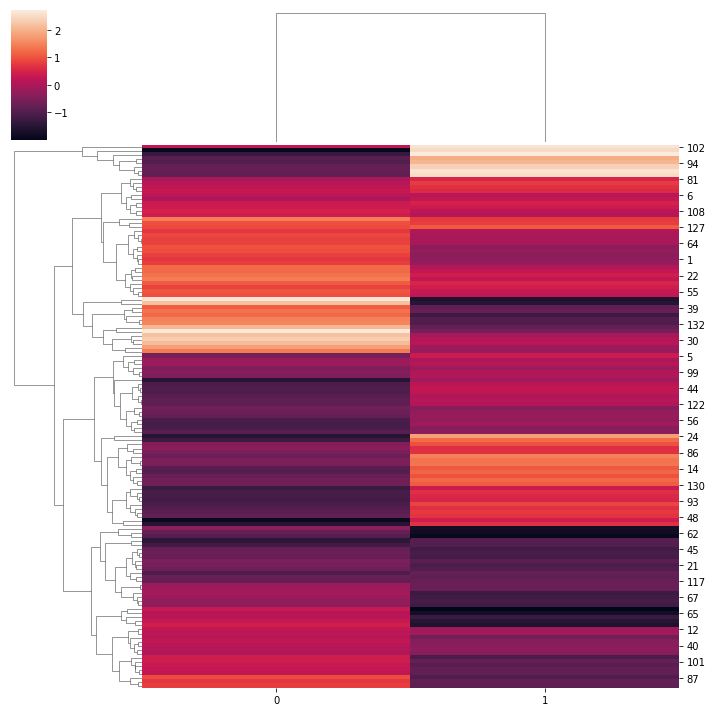

In [28]:
sns.clustermap(X)

When we analyzed the silhouette scores of the clusters and the dendogram, we chose 5 for the number of clusters.

## Kmeans Clustering

Let's run the K-Means algorithm

In [29]:
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(X)
clusters = kmeans.predict(X)
centroids = kmeans.cluster_centers_

In [30]:
clustering_gmt_df['cluster'] = clusters
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  ...  residential_percent_change_from_baseline
0        0  ...                                 14.165861
1        1  ...                                  6.388462
2        2  ...                                  2.383007
3        3  ...                                  6.805915
4        4  ...                                  0.404687

[5 rows x 7 columns]

In [31]:
print_clusters(range(n_clusters))



0. cluster
--------------------------------------------------------------------------------------------------------------------
['Bolivia', 'Cambodia', 'Chile', 'Ecuador', 'Fiji', 'Ghana', 'India', 'Kuwait', 'Malaysia', 'Myanmar (Burma)', 'Panama', 'Peru', 'Philippines', 'Rwanda', 'Singapore', 'South Africa', 'Sri Lanka', 'Uganda', 'Venezuela'] 
--------------------------------------------------------------------------------------------------------------------


1. cluster
--------------------------------------------------------------------------------------------------------------------
['Afghanistan', 'Angola', 'Aruba', 'Austria', 'Bangladesh', 'Barbados', 'Belgium', 'Belize', 'Benin', 'Botswana', 'Canada', 'Czechia', 'Estonia', 'France', 'Georgia', 'Ireland', 'Israel', 'Italy', 'Latvia', 'Luxembourg', 'Malta', 'Mongolia', 'Nepal', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovakia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States',

In [32]:
df0 = clusterCountries(range(n_clusters))

## Kmeans Visualization on world map

In [33]:
showMap(df0)

Interestingly, we observe that neighboring countries are the same color on the map this time. This shows us that 2-dimensional clustering gives better results. Looking at the map, we can assume that there is a relation between the rate of change in parks and settlements and geography. Although we can observe the distribution of clusters on the map, we also need other datasets to more accurately determine the relations between countries belonging to the same cluster.

However, we can say that the movements of the countries of the same color in the parks and settlements during the covid pandemic process are similar.

## 2 Dimensional Clustering for workplace and retail&recreation change from baseline

This time we will examine two different categories (workplaces and retail recreation). We thought that workplaces and places of entertainment were among the mobility categories with the highest risk of disease transmission, and we examined the differences in behavior between countries in these places during covid-19.

## Silhuette Analysis

We determine the number of clusters we will give to the K-Means algorithm again according to the Silhouette scores.

For n_clusters = 3 The average silhouette_score is : 0.36453682369249135
For n_clusters = 4 The average silhouette_score is : 0.3232828495535676
For n_clusters = 5 The average silhouette_score is : 0.3398598128220286
For n_clusters = 6 The average silhouette_score is : 0.3377028335782915
For n_clusters = 7 The average silhouette_score is : 0.3231951465408753


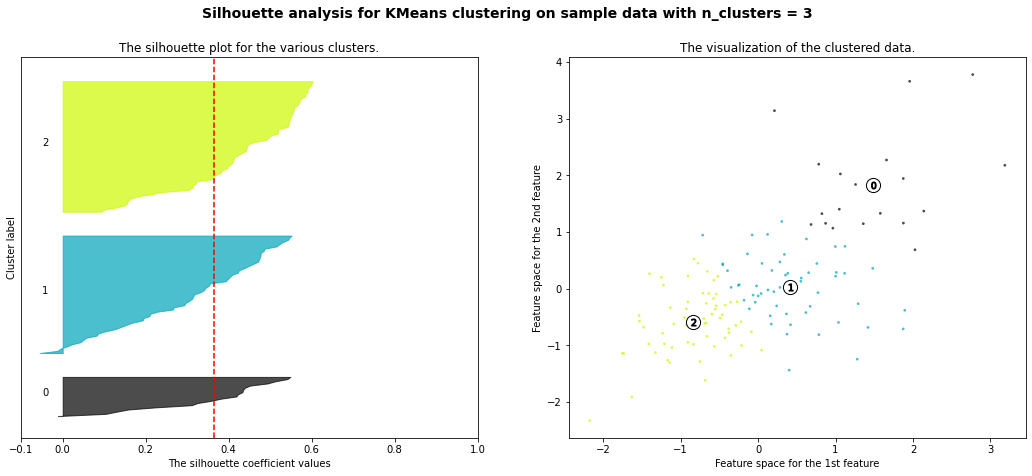

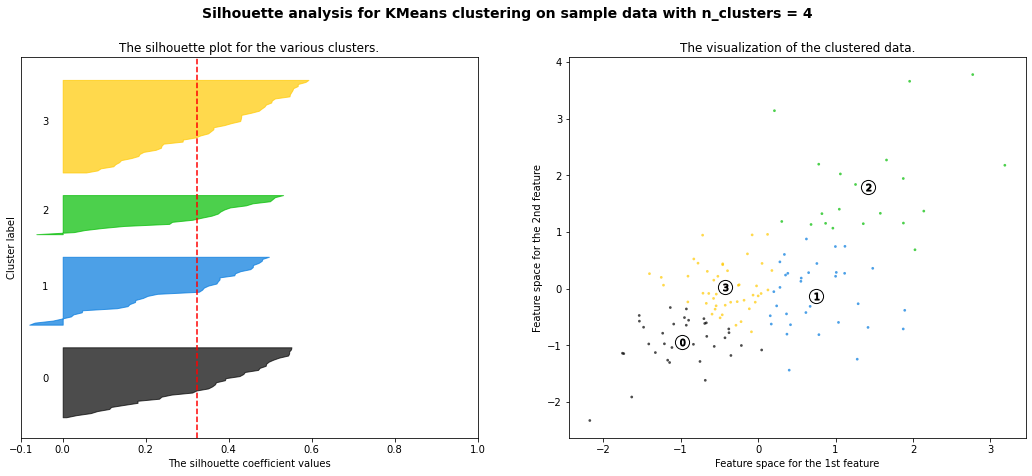

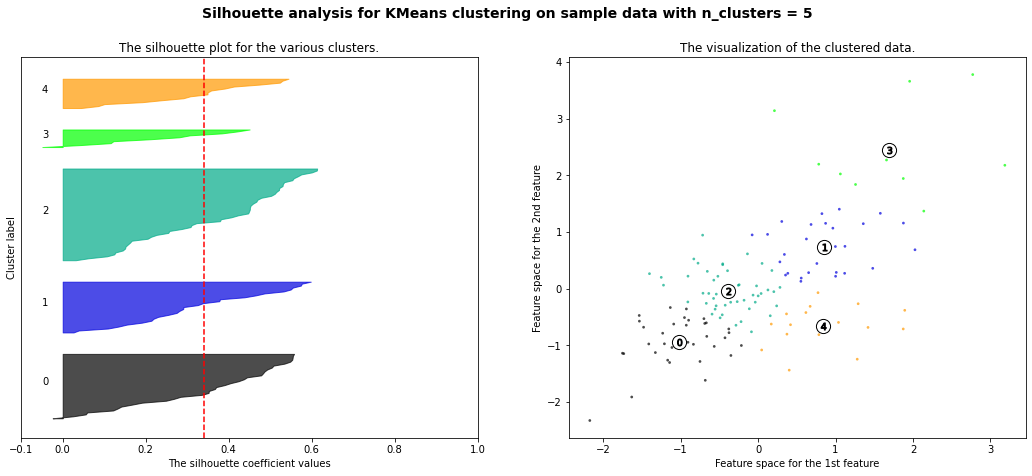

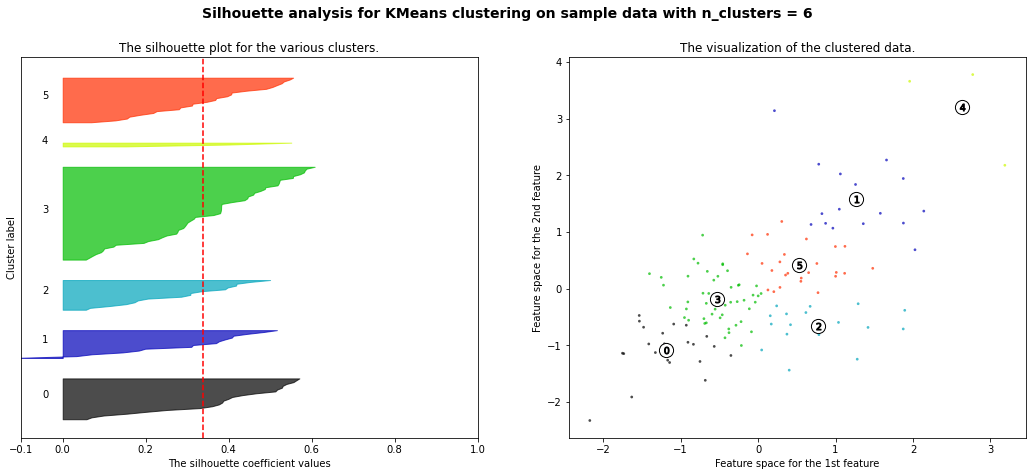

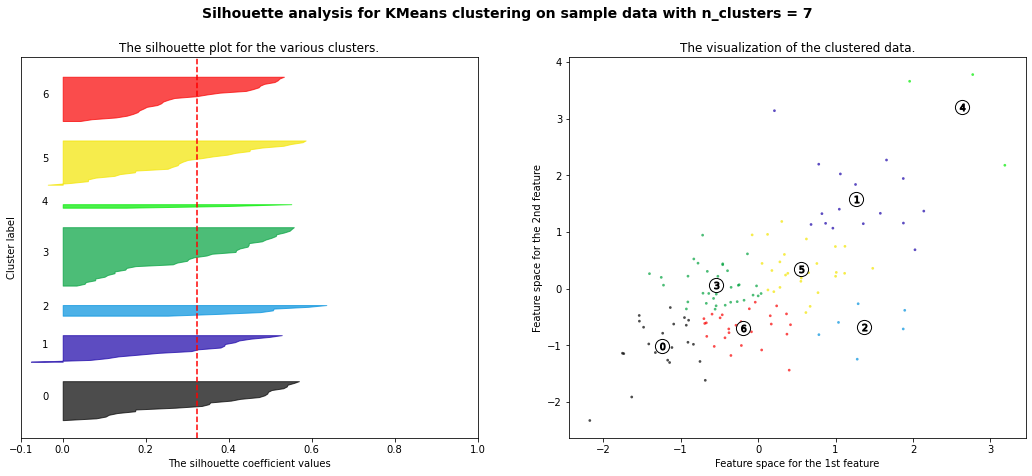

In [34]:
clustering_gmt_df = data.groupby('country_region').mean().reset_index() ##resetting
dim2_clustering_df = clustering_gmt_df[['workplaces_percent_change_from_baseline', 'retail_and_recreation_percent_change_from_baseline']]
dim2_clustering_df = dim2_clustering_df.fillna(0)
X = StandardScaler().fit_transform(dim2_clustering_df)
n = silhouetteAnalysis(X)

## Dendogram

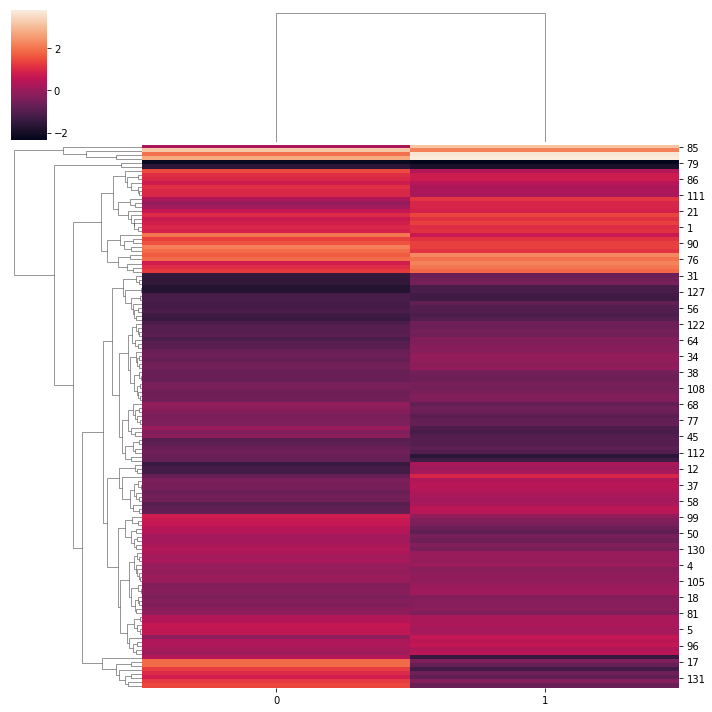

In [35]:
sns.clustermap(X)

## Kmeans clustering

Let's run the K-means algorithm

In [36]:
n_clusters = n
kmeans = KMeans(n_clusters)
kmeans.fit(X)
clusters = kmeans.predict(X)
centroids = kmeans.cluster_centers_

In [37]:
clustering_gmt_df['cluster'] = clusters
clustering_gmt_df.groupby('cluster').mean().reset_index()

cluster  ...  residential_percent_change_from_baseline
0        0  ...                                  5.650548
1        1  ...                                  3.674154
2        2  ...                                  6.709429

[3 rows x 7 columns]

In [38]:
print_clusters(range(n_clusters))



0. cluster
--------------------------------------------------------------------------------------------------------------------
['Argentina', 'Aruba', 'Australia', 'Bahrain', 'Belarus', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Cameroon', 'Chile', 'Colombia', 'Croatia', 'Czechia', 'Denmark', 'Egypt', 'Estonia', 'Fiji', 'Finland', 'Gabon', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Japan', 'Malta', 'Mauritius', 'Mexico', 'Mozambique', 'Namibia', 'Nepal', 'New Zealand', 'Nicaragua', 'Nigeria', 'Paraguay', 'Poland', 'Qatar', 'Rwanda', 'Réunion', 'Saudi Arabia', 'Senegal', 'South Africa', 'South Korea', 'Taiwan', 'Tajikistan', 'Tanzania', 'Thailand', 'Turkey', 'Uganda', 'United Arab Emirates', 'United States', 'Uruguay', 'Venezuela', 'Vietnam'] 
--------------------------------------------------------------------------------------------------------------------


1. cluster
---------------------------------------------------------------------------------------

## Kmeans Visualization on world map

In [39]:
df0 = clusterCountries(range(n_clusters))
showMap(df0)

A little different from the previous map, we see that North America and almost all of Europe are the same color. On the other hand, South American countries are gathered in a separate cluster.

Although we see once again the effect of geography on the mobility of countries, it does not seem possible with the data we have to say the reason or type of the relationship with certainty. A more meaningful model can be put forward if situations such as the effect of a possible temperature or climate, the existence of a cultural effect are also included. However, it would not be a lie to say that the current model gives results beyond my expectations.

## Other References

Comparison of clusterin algorithms
https://medium.com/analytics-vidhya/comparative-study-of-the-clustering-algorithms-54d1ed9ea732

Impression on world map with folium
https://geopandas.org/en/stable/gallery/plotting_with_folium.html

Receiving and examining the mobility reports of the countries
https://www.kaggle.com/jkalamar/exploring-the-google-and-apple-mobility-data

XINGYU BIAN - Coronavirus (COVID-19) Visualization & Prediction

GEORGII VYSHNIA - CoronaVirus Pandemic and Google Mobility Trend EDA (2020)

A simple example of using geopandas and folium together
https://www.learnpythonwithrune.org/plot-world-data-to-map-using-python-in-3-easy-steps/

## Comments About Project & Future Research Opinions

With this study, we clustered the countries according to the activity during the Covid period and found very surprising and meaningful results. However, we are talking about a 2-year disease period, and in this process, we went through a difficult process when we said the second and third waves, multiple quarantine periods, and the relative normalization periods when the disease decreased. However, averaging the categories while making these clusters decreased the efficiency of our model.

I think about developing a time dependent clustering model on the world map to develop the model so that a more meaningful model can be revealed.

Example for a time dependent animation.
https://towardsdatascience.com/how-to-create-an-animated-choropleth-map-with-less-than-15-lines-of-code-2ff04921c60b